In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

from collocation import compute_weights, lagrange_derivative

import preprocess # helper preprocessing class
import ode_solver_pyomo_base
import ode_solver_pyomo_opt

# pyomo
import importlib
import nn_pyomo_base
import nn_pyomo_base_dae

In [4]:
from datetime import datetime, timedelta

# prepare data ranges
START_DATE = '2015-01-10'
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
date_sequences = [start_date + timedelta(days=i*5) for i in range(5)]
date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
print(date_sequences_str)

times_elapsed = []

['2015-01-10', '2015-01-15', '2015-01-20', '2015-01-25', '2015-01-30']


---

In [11]:
import collocation
compute_weights = collocation.compute_weights

In [12]:
# reload the necessary libraries
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

importlib.reload(ode_solver_pyomo_opt)
DirectODESolver = ode_solver_pyomo_opt.DirectODESolver

# set up data parameters
file_path = '../00_data/df_train.csv'
# , 'temperature': 'var1'                                               
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

# fix model parameters 
layer_sizes = [7, 30, 1]

# fix optimal parameters
tol = 1e-6
params_nn = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 1000,
        'warm_start_init_point': 'yes' }

tol = 1e-4
params_ode = {"tol":1e-4, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_iter": 0,  
        "halt_on_ampl_error" : 'yes',
        "print_level": 1, 
        "max_iter": 100 }

In [15]:
jnp.array(df_train['t'])

Array([0.00000000e+00, 3.10745438e-05, 1.24290431e-04, 2.79624430e-04,
       4.97037828e-04, 7.76476442e-04, 1.11787063e-03, 1.52113531e-03,
       1.98616997e-03, 2.51285873e-03, 3.10107032e-03, 3.75065815e-03,
       4.46146032e-03, 5.23329969e-03, 6.06598390e-03, 6.95930543e-03,
       7.91304164e-03, 8.92695484e-03, 1.00007923e-02, 1.11342865e-02,
       1.23271549e-02, 1.35791002e-02, 1.48898103e-02, 1.62589588e-02,
       1.76862042e-02, 1.91711909e-02, 2.07135489e-02, 2.23128937e-02,
       2.39688267e-02, 2.56809353e-02, 2.74487927e-02, 2.92719585e-02,
       3.11499781e-02, 3.30823836e-02, 3.50686933e-02, 3.71084123e-02,
       3.92010322e-02, 4.13460315e-02, 4.35428755e-02, 4.57910168e-02,
       4.80898952e-02, 5.04389376e-02, 5.28375587e-02, 5.52851606e-02,
       5.77811334e-02, 6.03248550e-02, 6.29156914e-02, 6.55529971e-02,
       6.82361147e-02, 7.09643754e-02, 7.37370995e-02, 7.65535958e-02,
       7.94131624e-02, 8.23150867e-02, 8.52586455e-02, 8.82431051e-02,
      

In [16]:
data_loader = DataPreprocessor(file_path, start_date = date_sequences_str[0], number_of_points = 400, n_days = 1, m = 1, feature_encoding = encoding, split = 200)
data_subsample = data_loader.load_data()
df_train, df_test = data_loader.preprocess_data(data_subsample)
    
ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.atleast_2d(df_train.drop(columns=['y', 't']))

w = compute_weights(jnp.array(df_train['t']))
Ds = np.array(lagrange_derivative(df_train['t'], w))

importlib.reload(nn_pyomo_base)
NeuralODEPyomo = nn_pyomo_base.NeuralODEPyomo

ode_model = NeuralODEPyomo(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = ys,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.000, 
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params_nn
                        )

ode_model.build_model()
result = ode_model.solve_model_checkpoints(iter_per_check = 50)

y
Total max iterations: 1000
Ipopt 3.14.16: tol=1e-06
dual_inf_tol=1e-06
compl_inf_tol=1e-06
constr_viol_tol=1e-06
halt_on_ampl_error=yes
print_level=1
max_iter=50
warm_start_init_point=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.
Ipopt 3.14.16: tol=1e-06
dual_inf_tol=1e-06
compl_inf_tol=1e-06
constr_viol_tol=1e-06
halt_on_ampl_error=yes
print_level=1
max_iter=50
warm_start_init_point=yes


******************************************************************************
This program contains Ipo

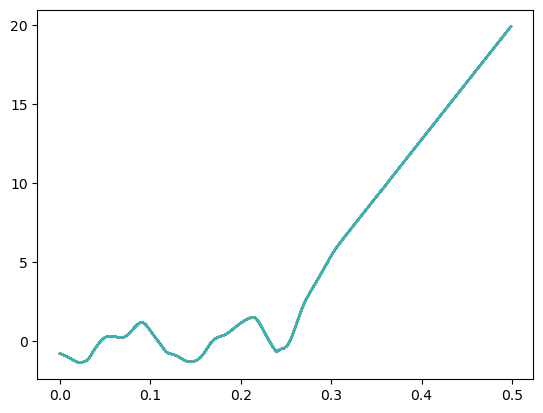

In [17]:
y_predictions = result[-1]

for y_pred in y_predictions:
    plt.plot(ts, y_pred)

### `Derivative Sanity Check`

In [21]:
dy_dt = []
for i in range(len(Ds)):
    dy_dt.append(jnp.dot(Ds[i], ys).item())

In [25]:
dy_dt_np = np.gradient(np.squeeze(ys), ts)

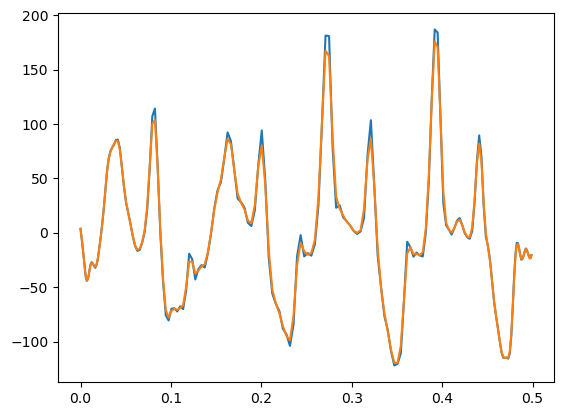

In [26]:
plt.plot(ts, dy_dt)
plt.plot(ts, dy_dt_np)

---
---

In [5]:
# reload the necessary libraries
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

importlib.reload(ode_solver_pyomo_opt)
DirectODESolver = ode_solver_pyomo_opt.DirectODESolver

# set up data parameters
file_path = '../00_data/df_train.csv'
# , 'temperature': 'var1'                                               
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}


# fix optimal parameters
tol = 1e-5
params_nn = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 3000,
        'warm_start_init_point': 'yes' }

tol = 1e-4
params_ode = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_iter": 0,  
        "halt_on_ampl_error" : 'yes',
        "print_level": 1, 
        "max_iter": 100 }

* increasing the hidden layer size of the model

In [7]:
importlib.reload(nn_pyomo_base)
NeuralODEPyomo = nn_pyomo_base.NeuralODEPyomo

experiment_results = {}
reload = True

#tol_li = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
tol_li = [1e-2, 1e-3, 1e-4, 1e-5]

# fix model parameters 
layer_sizes = [7, 50, 1]

PENALTY = 0.0

for tol in tol_li:
    params_nn = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 3000,
        'warm_start_init_point': 'yes'}
    
    experiment_results[tol] = {}
    
    for START_DATE in date_sequences_str:
        data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 1, feature_encoding = encoding, split = 200)
        data_subsample = data_loader.load_data()
        df_train, df_test = data_loader.preprocess_data(data_subsample)

        ys = np.atleast_2d(df_train['y']).T
        ts = np.array(df_train['t'])
        Xs = np.atleast_2d(df_train.drop(columns=['y', 't']))

        if reload or Ds.shape[0] != len(ts):
            reload = False
            w = compute_weights(df_train['t'])
            Ds = np.array(lagrange_derivative(df_train['t'], w))

        ode_model = NeuralODEPyomo(y_observed = ys, 
                                t = ts, # t
                                first_derivative_matrix = Ds, # derivative matrix
                                extra_input = Xs, # extra inputs
                                y_init = ys,
                                layer_sizes = layer_sizes, act_func = "tanh", 
                                penalty_lambda_reg = PENALTY, 
                                time_invariant = True,
                                w_init_method = 'xavier', 
                                params = params_nn
                                )

        ode_model.build_model()
        result = ode_model.solve_model()
        u_model = ode_model.extract_solution().T
        
        experiment_results[tol][START_DATE] = {}
        experiment_results[tol][START_DATE]['result'] = result
        experiment_results[tol][START_DATE]['times_elapsed'] = result['solver_time']
        
        # ---------------------------------------------- ODEINT PREDICTION ----------------------------------------------
        y_pred = ode_model.neural_ode(ys[0], ts, (Xs, ts))
        
        experiment_results[tol][START_DATE]['mae_odeint'] = np.mean(np.abs(np.squeeze(y_pred) - np.squeeze(ys)))
        experiment_results[tol][START_DATE]['mse_odeint'] = np.mean(np.square(np.squeeze(y_pred) - np.squeeze(ys)))
        
        # -------------------------------------------- COLLOCATION PREDICTION (TRAIN) ---------------------------------------------- 
        # extract weights & biases
        trained_weights_biases = ode_model.extract_weights()  
        
        # set up and solve the model
        initial_state = u_model[0]
        direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights_biases, initial_state, 
                                        D = Ds, 
                                        time_invariant=True, extra_input=np.array(Xs), params = params_ode)
        direct_solver.build_model()
        solver_info = direct_solver.solve_model()
        y_solution = direct_solver.extract_solution()     
        
        experiment_results[tol][START_DATE]['mae_coll_ode'] = np.mean(np.abs(np.squeeze(y_solution) - np.squeeze(ys)))
        experiment_results[tol][START_DATE]['mse_coll_ode'] = np.mean(np.square(np.squeeze(y_solution) - np.squeeze(ys)))
        
        # ---------------------------------------- ODEINT & COLLOCATION PREDICTION (TEST) ----------------------------------------- 
        ys_test = np.atleast_2d(df_test['y']).T
        ts_test = np.array(df_test['t'])
        Xs_test = np.atleast_2d(df_test.drop(columns=['y', 't']))
        w_test = compute_weights(df_test['t'])
        Ds_test = np.array(lagrange_derivative(df_test['t'].values, w_test))
        
        # odeint prediction
        y_pred_test = ode_model.neural_ode(ys_test[0], ts_test, (Xs_test, ts_test))
        
        experiment_results[tol][START_DATE]['mae_odeint_test'] = np.mean(np.abs(np.squeeze(y_pred_test) - np.squeeze(ys_test)))
        experiment_results[tol][START_DATE]['mse_odeint_test'] = np.mean(np.square(np.squeeze(y_pred_test) - np.squeeze(ys_test)))
        
        y0_test = ys_test[0][0]
        direct_solver = DirectODESolver(ts_test, layer_sizes, trained_weights_biases, y0_test, 
                                        D = Ds_test,
                                        time_invariant=True, extra_input=np.array(Xs_test), params = params_ode)
        direct_solver.build_model()
        
        solver_info = direct_solver.solve_model()
        y_solution_test = direct_solver.extract_solution() 
        
        experiment_results[tol][START_DATE]['mae_coll_ode_test'] = np.mean(np.abs(np.squeeze(y_solution_test) - np.squeeze(ys_test)))
        experiment_results[tol][START_DATE]['mse_coll_ode_test'] = np.mean(np.square(np.squeeze(y_solution_test) - np.squeeze(ys_test)))
        
        print(f"Processing for {START_DATE} is complete")

y
Ipopt 3.14.16: tol=0.01
halt_on_ampl_error=yes
print_level=5
max_iter=3000
warm_start_init_point=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   129500
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    91900

Total number of variables............................:      651
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      651
                     variables with only upper bound

In [71]:
experiment_results[0.01]

{'2015-01-10': {'result': {'solver_time': 4.422704219818115,
   'termination_condition': <TerminationCondition.optimal: 'optimal'>,
   'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'},
  'times_elapsed': 4.422704219818115,
  'mae_odeint': 38.647455238896036,
  'mse_odeint': 2415.138490342597,
  'mae_coll_ode': 0.13115159377078003,
  'mse_coll_ode': 0.08858128625130338,
  'mae_odeint_test': 41.55112165631732,
  'mse_odeint_test': 2675.1210066729623,
  'mae_coll_ode_test': 0.458931761683919,
  'mse_coll_ode_test': 0.3537905347038144}}

In [67]:
results = experiment_results[0.01]
print(f"MAE train (odeint): {np.mean([results[k]['mae_odeint'] for k in results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([results[k]['mae_odeint_test'] for k in results.keys()]):.3f}")
print(f"MAE train: {np.mean([results[k]['mae_coll_ode'] for k in results.keys()]):.3f}")
print(f"MAE test: {np.mean([results[k]['mae_coll_ode_test'] for k in results.keys()]):.3}")
print(f"MSE train: {np.mean([results[k]['mse_coll_ode'] for k in results.keys()]):.3f}")
print(f"MSE test: {np.mean([results[k]['mse_coll_ode_test'] for k in results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([results[k]['times_elapsed'] for k in results.keys()]):.3} seconds")

MAE train (odeint): 38.647
MAE test (odeint): 41.551
MAE train: 0.131
MAE test: 0.459
MSE train: 0.089
MSE test: 0.354
Avg sovler time elapsed: 4.42 seconds


In [68]:
results = experiment_results[0.001]
print(f"MAE train (odeint): {np.mean([results[k]['mae_odeint'] for k in results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([results[k]['mae_odeint_test'] for k in results.keys()]):.3f}")
print(f"MAE train: {np.mean([results[k]['mae_coll_ode'] for k in results.keys()]):.3f}")
print(f"MAE test: {np.mean([results[k]['mae_coll_ode_test'] for k in results.keys()]):.3}")
print(f"MSE train: {np.mean([results[k]['mse_coll_ode'] for k in results.keys()]):.3f}")
print(f"MSE test: {np.mean([results[k]['mse_coll_ode_test'] for k in results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([results[k]['times_elapsed'] for k in results.keys()]):.3} seconds")

MAE train (odeint): 38.067
MAE test (odeint): 40.346
MAE train: 0.131
MAE test: 0.444
MSE train: 0.092
MSE test: 0.327
Avg sovler time elapsed: 5.01 seconds


In [69]:
results = experiment_results[0.0001]
print(f"MAE train (odeint): {np.mean([results[k]['mae_odeint'] for k in results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([results[k]['mae_odeint_test'] for k in results.keys()]):.3f}")
print(f"MAE train: {np.mean([results[k]['mae_coll_ode'] for k in results.keys()]):.3f}")
print(f"MAE test: {np.mean([results[k]['mae_coll_ode_test'] for k in results.keys()]):.3}")
print(f"MSE train: {np.mean([results[k]['mse_coll_ode'] for k in results.keys()]):.3f}")
print(f"MSE test: {np.mean([results[k]['mse_coll_ode_test'] for k in results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([results[k]['times_elapsed'] for k in results.keys()]):.3} seconds")

MAE train (odeint): 38.220
MAE test (odeint): 40.965
MAE train: 0.131
MAE test: 0.444
MSE train: 0.092
MSE test: 0.327
Avg sovler time elapsed: 3.76 seconds


In [16]:
results = experiment_results[0.01]
print(f"MAE train (odeint): {np.mean([results[k]['mae_odeint'] for k in results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([results[k]['mae_odeint_test'] for k in results.keys()]):.3f}")
print(f"MAE train: {np.mean([results[k]['mae_coll_ode'] for k in results.keys()]):.3f}")
print(f"MAE test: {np.mean([results[k]['mae_coll_ode_test'] for k in results.keys()]):.3}")
print(f"MSE train: {np.mean([results[k]['mse_coll_ode'] for k in results.keys()]):.3f}")
print(f"MSE test: {np.mean([results[k]['mse_coll_ode_test'] for k in results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([results[k]['times_elapsed'] for k in results.keys()]):.3} seconds")

MAE train (odeint): 0.131
MAE test (odeint): 0.268
MAE train: 0.421
MAE test: 0.647
MSE train: 0.381
MSE test: 0.717
Avg sovler time elapsed: 45.0 seconds


In [17]:
results = experiment_results[0.001]
print(f"MAE train (odeint): {np.mean([results[k]['mae_odeint'] for k in results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([results[k]['mae_odeint_test'] for k in results.keys()]):.3f}")
print(f"MAE train: {np.mean([results[k]['mae_coll_ode'] for k in results.keys()]):.3f}")
print(f"MAE test: {np.mean([results[k]['mae_coll_ode_test'] for k in results.keys()]):.3}")
print(f"MSE train: {np.mean([results[k]['mse_coll_ode'] for k in results.keys()]):.3f}")
print(f"MSE test: {np.mean([results[k]['mse_coll_ode_test'] for k in results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([results[k]['times_elapsed'] for k in results.keys()]):.3} seconds")

MAE train (odeint): 0.131
MAE test (odeint): 0.268
MAE train: 0.421
MAE test: 0.647
MSE train: 0.381
MSE test: 0.717
Avg sovler time elapsed: 50.0 seconds


In [18]:
results = experiment_results[0.0001]
print(f"MAE train (odeint): {np.mean([results[k]['mae_odeint'] for k in results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([results[k]['mae_odeint_test'] for k in results.keys()]):.3f}")
print(f"MAE train: {np.mean([results[k]['mae_coll_ode'] for k in results.keys()]):.3f}")
print(f"MAE test: {np.mean([results[k]['mae_coll_ode_test'] for k in results.keys()]):.3}")
print(f"MSE train: {np.mean([results[k]['mse_coll_ode'] for k in results.keys()]):.3f}")
print(f"MSE test: {np.mean([results[k]['mse_coll_ode_test'] for k in results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([results[k]['times_elapsed'] for k in results.keys()]):.3} seconds")

MAE train (odeint): 0.131
MAE test (odeint): 0.268
MAE train: 0.421
MAE test: 0.647
MSE train: 0.381
MSE test: 0.717
Avg sovler time elapsed: 52.0 seconds


In [42]:
if optimal not in result['termination_condition'];

SyntaxError: invalid syntax (4070895684.py, line 1)

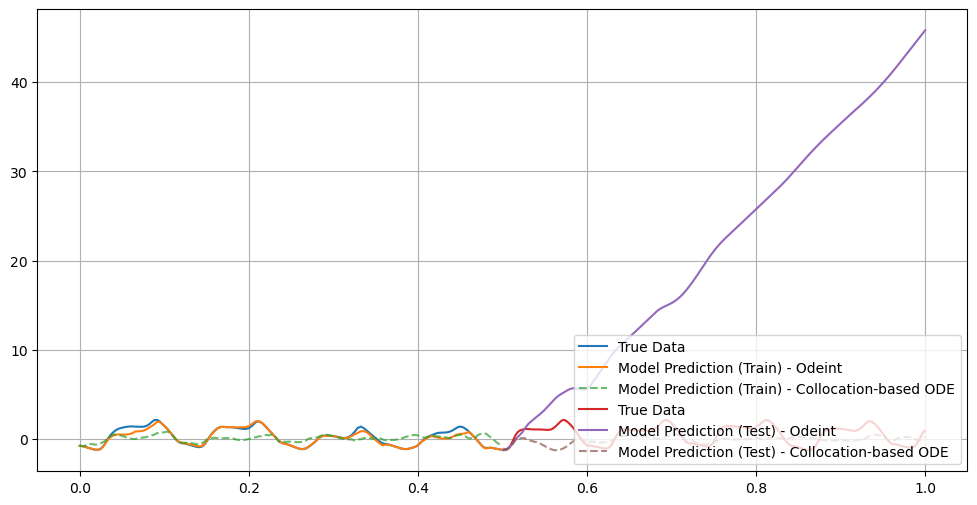

In [48]:
ts_pred = ts
y_pred = ode_model.neural_ode_odeint(ys[0], ts, (Xs, ts))
ts_test_pred = ts_test
y_pred_test = ode_model.neural_ode(ys_test[0], ts_test, (Xs_test, ts_test))
display = True

if display:
    plt.figure(figsize=(12, 6))
    plt.plot(ts, ys, label='True Data', alpha = 1)
    plt.plot(ts_pred, y_pred, label='Model Prediction (Train) - Odeint', alpha = 1)
    plt.plot(ts, y_solution, '--', label='Model Prediction (Train) - Collocation-based ODE', alpha = 0.7)
    
    plt.plot(ts_test, ys_test, label='True Data', alpha = 1)
    plt.plot(ts_test_pred, y_pred_test, label='Model Prediction (Test) - Odeint', alpha = 1)
    plt.plot(ts_test, y_solution_test, '--', label='Model Prediction (Test) - Collocation-based ODE', alpha = 0.7)
    # y_test_test y_solution_test
    #plt.title(f"Collocation-based ODE solver Result; Time Elapsed: {result['solver_time']}")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.show()

In [44]:
[experiment_results[k]['mae_odeint_test'] for k in experiment_results.keys()]

[21.10689786724623]

# No Regularization

#### Tolerance `1e-2`

In [59]:
print(f"MAE train (odeint): {np.mean([experiment_results[k]['mae_odeint'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([experiment_results[k]['mae_odeint_test'] for k in experiment_results.keys()]):.3f}")
print(f"MAE train: {np.mean([experiment_results[k]['mae_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test: {np.mean([experiment_results[k]['mae_coll_ode_test'] for k in experiment_results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([experiment_results[k]['times_elapsed'] for k in experiment_results.keys()]):.3} seconds")

MAE train (odeint): 5.325
MAE test (odeint): 8.499
MAE train: 0.411
MAE test: 0.799
Avg sovler time elapsed: 3.95 seconds


#### Tolerance `1e-3`

In [54]:
print(f"MAE train (odeint): {np.mean([experiment_results[k]['mae_odeint'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([experiment_results[k]['mae_odeint_test'] for k in experiment_results.keys()]):.3f}")
print(f"MAE train: {np.mean([experiment_results[k]['mae_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test: {np.mean([experiment_results[k]['mae_coll_ode_test'] for k in experiment_results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([experiment_results[k]['times_elapsed'] for k in experiment_results.keys()]):.3} seconds")

MAE train (odeint): 0.317
MAE test (odeint): 0.568
MAE train: 0.203
MAE test: 0.461
Avg sovler time elapsed: 12.7 seconds


In [56]:
len(experiment_results)

10

#### Tolerance `1e-4`

In [35]:
print(f"MAE train (odeint): {np.mean([experiment_results[k]['mae_odeint'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([experiment_results[k]['mae_odeint_test'] for k in experiment_results.keys()]):.3f}")
print(f"MAE train: {np.mean([experiment_results[k]['mae_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test: {np.mean([experiment_results[k]['mae_coll_ode_test'] for k in experiment_results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([experiment_results[k]['times_elapsed'] for k in experiment_results.keys()]):.3} seconds")

MAE train (odeint): 0.138
MAE test (odeint): 2.520
MAE train: 0.528
MAE test: 0.593
Avg sovler time elapsed: 23.6 seconds


#### Tolerance `1e-5`

In [62]:
print(f"MAE train (odeint): {np.mean([experiment_results[k]['mae_odeint'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test (odeint): {np.mean([experiment_results[k]['mae_odeint_test'] for k in experiment_results.keys()]):.3f}")
print(f"MAE train: {np.mean([experiment_results[k]['mae_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MAE test: {np.mean([experiment_results[k]['mae_coll_ode_test'] for k in experiment_results.keys()]):.3}")
print(f"Avg sovler time elapsed: {np.mean([experiment_results[k]['times_elapsed'] for k in experiment_results.keys()]):.3} seconds")

MAE train (odeint): 0.140
MAE test (odeint): 2.110
MAE train: 0.686
MAE test: 0.765
Avg sovler time elapsed: 50.0 seconds
